# Calculate robusteness from pi control runs

In [38]:
# Some definitions

# directory of data
#fdir = '~/Google Drive/professional/research/FARALLON_INSTITUTE_PROJECTS/2020 NOAA MAPP/Climate_extremes_sharedfigsandcode/data/FOR SCATTER PLOT/'
fdir = '/Volumes/GoogleDrive/My Drive/Climate_extremes_sharedfigsandcode/data/Annual_TimeSeries/'

In [39]:
# Modules
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore') #filter some warning messages
import seaborn as sns

In [40]:
#detrend function: detrend use polynomial fit
def detrend(x,y,degree):
    import statsmodels.formula.api as smf
    import numpy as np
    import pandas as pd
    

    df = pd.DataFrame(columns=['y', 'x'])
    df['x'] = x
    df['y'] = pd.Series(y)   #y

    idx = np.isfinite(x) & np.isfinite(y)
    weights = np.polyfit(x[idx], y[idx], degree)
    model = np.poly1d(weights)
    results = smf.ols(formula='y ~ model(x)', data=df).fit()

    p_value=results.f_pvalue
    r2=results.rsquared_adj

    detrend_ts=np.zeros(shape=(len(y),))
    detrend_ts[:] = np.nan
    detrend_ts[idx]=y[idx]-results.fittedvalues

    #plt.figure(figsize=(10,4))
    #plt.plot(x,y)
    #plt.plot(x[idx], results.fittedvalues, 'r')
    #plt.figure(figsize=(10,4))
    #plt.plot(x, detrend_ts)
    #plt.show()

    return p_value, r2, detrend_ts

In [41]:
def num_coevents(y1, y2, pct1, pct2,  runs='picontrol',loc='cclme'):
    # 
    fin1 = fdir+'original ts/'+runs+'_'+loc+'_sst.nc'
    fin2 = fdir+'original ts/'+runs+'_goa_sst.nc'
    fin3 = fdir+'original ts/'+runs+'_sm.nc'

    modsst = xr.open_dataset(fin1)
    modsst.close()
    modsm2 = xr.open_dataset(fin2)
    modsm2.close()
    
    modsm = xr.open_dataset(fin3)
    modsm.close()    
    models = modsm.model

    # selec periood
    modsst = modsst.sel(year=slice(y1,y2))
    modsm2 = modsm2.sel(year=slice(y1-1,y2-1))
    modsm = modsm.sel(year=slice(y1-1,y2-1))
    
    drt_a = list()
    mhw_a = list() 
    
    for ix,i in enumerate(models):
        #print(ix,i)
        tmp1_0= modsst.sel(model=i).sst.values
        tmp2_0= modsm2.sel(model=i).sst.values
        tmp3_0= modsm.sel(model=i).sm.values

        
        #detrend
        nsample = np.linspace(1,len(tmp1_0), len(tmp1_0))
        [p_value, r2, tmp1]= detrend(nsample,tmp1_0,1)
        nsample = np.linspace(1,len(tmp2_0), len(tmp2_0))
        [p_value, r2, tmp2]= detrend(nsample,tmp2_0,1)
        nsample = np.linspace(1,len(tmp3_0), len(tmp3_0))
        [p_value, r2, tmp3]= detrend(nsample,tmp3_0,1)
        
        # calculate threshold
        mhw_thr = np.nanpercentile(tmp1,pct1)
        drg_thr = np.nanpercentile(tmp2,pct1)
        drg_thr2 = np.nanpercentile(tmp3,pct2)
    
        a1 = tmp1>=mhw_thr
        a2 = tmp2>=drg_thr
        a3 = tmp3<=drg_thr2  
        
        tmp_m = np.full((len(modsst.year.values),1),np.nan)
        tmp_m[0:len(tmp1[a2]),0]=tmp1[a2]
        
        tmp_d = np.full((len(modsst.year.values),1),np.nan)
        tmp_d[0:len(tmp2[a2]),0]=tmp2[a2]
        
        mhw_a.append(tmp_m)
        drt_a.append(tmp_d)
        
    return mhw_a, drt_a 

In [42]:
ny =30
prc1 = 90
prc2 = 10
loc='cclme'
pi_m_a=list()
pi_d_a=list()

for i in range(int(500/ny)):
    mhw_a, drt_a  = num_coevents(i*ny+2, (i+1)*ny+1,prc1 , prc2, loc=loc)
    pi_m_a.append(mhw_a)
    pi_d_a.append(drt_a)


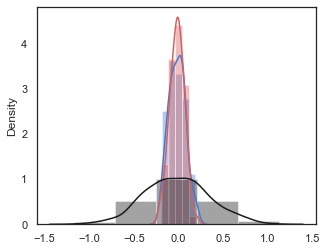

In [43]:
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True)
fig, ax1 = plt.subplots(figsize=(5,4))

ax1=sns.distplot(np.mean(np.array(pi_m_a),axis=(1)), bins=5,hist=True, color='b',label='PI')  #, ax=axes[0, 0])hist=False,

ax1=sns.distplot(np.mean(np.array(pi_m_a),axis=(0)), bins=5,hist=True, color='r',label='PI')  #, ax=axes[0, 0])hist=False,

ax1=sns.distplot(pi_m_a, bins=5,hist=True, color='k',label='PI')  #, ax=axes[0, 0])hist=False,


plt.show()

In [44]:
## Calculate thresholds for PI Control runs

In [45]:
def get_thre(fdir, runs,loc, y1,y2,prc1,prc2):
    # open data: anomalies (without trend)

    modsst = xr.open_dataset(fdir+'original ts/'+runs+'_'+loc+'_sst.nc')
    modsst.close()
    modsm2 = xr.open_dataset(fdir+'original ts/'+runs+'_goa_sst.nc')
    modsm2.close()
    modsm = xr.open_dataset(fdir+'original ts/'+runs+'_sm.nc')
    modsm.close()
    
    # select period 
    modsst = modsst.sel(year=slice(y1,y2))
    modsm2 = modsm2.sel(year=slice(y1-1,y2-1))
    modsm = modsm.sel(year=slice(y1-1,y2-1))

    mhw_thr = list()
    drg_thr = list()
    drg_thr2 = list()
    models = list()

    # Calculate thresholds for each model
    for ix,i in enumerate(modsm.model.values):
        tmp1_0= modsst.sel(model=i).sst.values
        tmp2_0= modsm2.sel(model=i).sst.values
        tmp3_0= modsm.sel(model=i).sm.values
        
        #detrend
        nsample = np.linspace(1,len(tmp1_0), len(tmp1_0))
        [p_value, r2, tmp1]= detrend(nsample,tmp1_0,1)
        nsample = np.linspace(1,len(tmp2_0), len(tmp2_0))
        [p_value, r2, tmp2]= detrend(nsample,tmp2_0,1)
        nsample = np.linspace(1,len(tmp3_0), len(tmp3_0))
        [p_value, r2, tmp3]= detrend(nsample,tmp3_0,1)
        
        mhw_thr.append(np.nanpercentile(tmp1,prc1))
        drg_thr.append(np.nanpercentile(tmp2,prc1))
        drg_thr2.append(np.nanpercentile(tmp3,prc2))


        models.append(i)
    
    return mhw_thr, drg_thr,drg_thr2, models

In [46]:
# calculate number of events for control, historical and future
# based on thresholds in each run

def freq_coevents(fdir, runs, loc, mhw_thr, drg_thr, drg_thr2, models, y1, y2):
    #pi control
    fi1 = fdir+'original ts/'+runs+'_'+loc+'_sst.nc'
    fi2 = fdir+'original ts/'+runs+'_goa_sst.nc'
    fi3 = fdir+'original ts/'+runs+'_sm.nc'

    modsst = xr.open_dataset(fi1)
    modsst.close()
    modsm2 = xr.open_dataset(fi2)
    modsm2.close()
    modsm = xr.open_dataset(fi3)
    modsm.close()
    # select period
    modsst = modsst.sel(year=slice(y1,y2))
    modsm2 = modsm2.sel(year=slice(y1-1,y2-1))
    modsm = modsm.sel(year=slice(y1-1,y2-1))

    drt_a = list()
    mhw_a = list()
    for ix,i in enumerate(models):
        #print(ix,i)
        tmp1_0= modsst.sel(model=i).sst.values
        tmp2_0= modsm2.sel(model=i).sst.values
        tmp3_0= modsm.sel(model=i).sm.values
        
        #detrend
        nsample = np.linspace(1,len(tmp1_0), len(tmp1_0))
        [p_value, r2, tmp1]= detrend(nsample,tmp1_0,1)
        nsample = np.linspace(1,len(tmp2_0), len(tmp2_0))
        [p_value, r2, tmp2]= detrend(nsample,tmp2_0,1)
        nsample = np.linspace(1,len(tmp3_0), len(tmp3_0))
        [p_value, r2, tmp3]= detrend(nsample,tmp3_0,1)
                
        
        a1 = tmp1>=mhw_thr[ix]
        a2 = tmp2>=drg_thr[ix]
        a3 = tmp3<=drg_thr2[ix]
        tmp_m = np.full((len(modsst.year.values),1),np.nan)
        tmp_m[0:len(tmp1[a2]),0]=tmp1[a2]
        
        tmp_d = np.full((len(modsst.year.values),1),np.nan)
        tmp_d[0:len(tmp2[a2]),0]=tmp2[a2]
        
        mhw_a.append(tmp_m)
        drt_a.append(tmp_d)

    
    return mhw_a, drt_a #mean no. of events

In [47]:
def freq_difruns(fdir,loc, ny, prc1, prc2):
    
    # calculate threshold in future 1
    y2=2099
    y1=y2-ny+1
    mhw_thr, drg_thr,drg_thr2, models = get_thre(fdir, 'ssp585',loc,y1,y2,prc1,prc2)

    # future 1
    y2=2099
    y1=y2-ny+1
    print('\nfuture: '+str(y1)+'-'+str(y2))
    mhw_a2, drt_a2 = freq_coevents(fdir,'ssp585',loc,mhw_thr,drg_thr, drg_thr2,models, y1,y2)


    return mhw_a2, drt_a2

In [48]:
# Frequency of events - detrended data, using individual threshols
## percentiles 90-10

In [49]:

print ('\nPercentiles: '+str(prc1)+'/'+str(prc2))
print('\nProbable # events in '+str(ny)+' years'+': '+str(ny*0.01))

#fu_m_a, fu_d_a=freq_difruns(fdir,loc,ny, prc1, prc2)
mhw_a2, drt_a2=freq_difruns(fdir,loc,ny, prc1, prc2)

fu_m_a=list()
fu_d_a=list()

for i in range(int(500/ny)):
    fu_m_a.append(mhw_a2)
    fu_d_a.append(drt_a2)


Percentiles: 90/10

Probable # events in 30 years: 0.3

future: 2070-2099


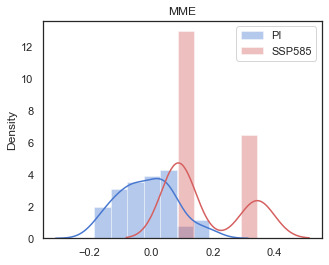

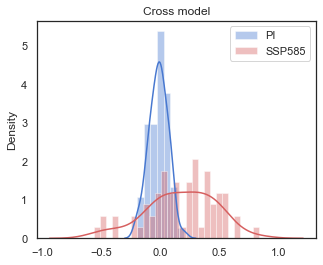

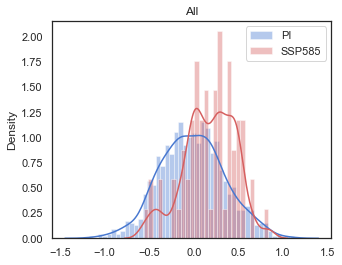

In [50]:
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True)
bw=0.05

fig, ax1 = plt.subplots(figsize=(5,4))
DS=np.nanmean(np.array(pi_m_a),axis=1)
nbin=int((max(DS.flatten())-min(DS.flatten()))/bw)
ax1=sns.distplot(np.nanmean(np.array(pi_m_a),axis=1), bins=nbin,hist=True, color='b',label='PI')  #, ax=axes[0, 0])hist=False,
DS=np.nanmean(np.array(fu_m_a),axis=1)
nbin=int((max(DS.flatten())-min(DS.flatten()))/bw)
ax1=sns.distplot(np.nanmean(np.array(fu_m_a),axis=1), bins=nbin,hist=True, color='r',label='SSP585')  #, ax=axes[0, 0])hist=False,
plt.title('MME')
plt.legend()
plt.show()

fig, ax1 = plt.subplots(figsize=(5,4))
DS=np.nanmean(np.array(pi_m_a),axis=0)
nbin=int((max(DS.flatten())-min(DS.flatten()))/bw)
ax1=sns.distplot(np.nanmean(np.array(pi_m_a),axis=0), bins=nbin,hist=True, color='b',label='PI')  #, ax=axes[0, 0])hist=False,
DS=np.nanmean(np.array(fu_m_a),axis=0)
nbin=int((max(DS.flatten())-min(DS.flatten()))/bw)
ax1=sns.distplot(np.nanmean(np.array(fu_m_a),axis=0), bins=nbin,hist=True, color='r',label='SSP585')  #, ax=axes[0, 0])hist=False,
plt.title('Cross model')
plt.legend()
plt.show()


fig, ax1 = plt.subplots(figsize=(5,4))
DS=np.array(pi_m_a)
nbin=int((max(DS.flatten())-min(DS.flatten()))/bw)
ax1=sns.distplot(pi_m_a, bins=nbin,hist=True, color='b',label='PI')  #, ax=axes[0, 0])hist=False,
DS=np.array(fu_m_a)
nbin=int((max(DS.flatten())-min(DS.flatten()))/bw)
ax1=sns.distplot(fu_m_a, bins=nbin,hist=True, color='r',label='SSP585')  #, ax=axes[0, 0])hist=False,                
plt.title('All')
plt.legend()
plt.show()

In [51]:
anom=[np.asarray(pi_m_a),np.asarray(pi_d_a),np.asarray(fu_m_a),np.asarray(fu_d_a)]
np.save('goa_'+loc+'_detrend_anom.npy',anom)